**Spam vs Ham classification using TF-IDF**

This project aims to develop a spam classifier using Natural Language Processing (NLP) and Machine Learning techniques. The goal is to accurately differentiate between spam and ham (non-spam) messages in the SMS text data.

In [470]:
#Importing Required Libraries 
import pandas as pd 
import numpy as np 
import  matplotlib.pyplot as plt
import seaborn as sns
import nltk 
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from sklearn.metrics import classification_report,balanced_accuracy_score,accuracy_score,precision_score,recall_score,f1_score,confusion_matrix

# classifiers 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier,RandomForestClassifier,ExtraTreesClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
import time

In [471]:
# Importing the dataset and creating the dataframe
df = pd.read_csv('spam.csv', encoding= 'latin-1')


**EDA**

In [472]:
# dataset 
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [473]:
# Dropping the unwanted columns 
df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis= 1, inplace= True)

In [474]:
# Dataset after dropping the columns 
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [475]:
# shappe of the dataset
df.shape

(5572, 2)

In [476]:
#no of duplicates 
df.duplicated().sum()

403

In [477]:
#deleting the duplicates
df.drop_duplicates(inplace = True)

In [478]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5169 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5169 non-null   object
 1   v2      5169 non-null   object
dtypes: object(2)
memory usage: 121.1+ KB


In [479]:
#renaming the column
df.rename(columns={'v1':'label','v2':'sms'}, inplace= True)
df.head()

,label,sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [480]:
#counting ham and spam
print(df.label.value_counts())

label
ham     4516
spam     653
Name: count, dtype: int64


In [481]:
# adding another column for length of the message 
df['length'] = df['sms'].apply(len)
df.head()

,label,sms,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


array([<Axes: title={'center': 'ham'}>, <Axes: title={'center': 'spam'}>],
      dtype=object)

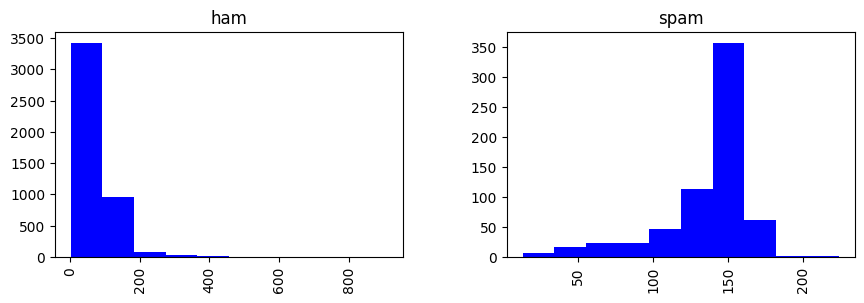

In [482]:
# visualizing the length of the message between ham and spam
df.hist(column = 'length', color = 'blue', by ='label',figsize = (10,3))

In [483]:
#stats info for the dataset 
df.groupby('label').describe().T

label                 ham        spam
length count  4516.000000  653.000000
       mean     70.459256  137.891271
       std      56.358207   30.137753
       min       2.000000   13.000000
       25%      34.000000  132.000000
       50%      52.000000  149.000000
       75%      90.000000  157.000000
       max     910.000000  224.000000

**Insights :**

1) There are 4516 ham and 653 spam messages

2) On average, the mean length of Ham messages is 70.46 characters while spam messages have a mean length of about 137.89 characters.

3) The message length of spam messages is negatively screwed while the message length of Ham messages is positively screwed i.e. the spam messages are longer than ham messages. 

4) The largest ham message contains 910 characters and largest spam message contains 224 characters 



In [484]:
df.head()

,label,sms,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [485]:
#mapping th label column with 0 and § 
df['label'].replace('ham',0,inplace = True)
df['label'].replace('spam',1,inplace = True)
df.head()

,label,sms,length
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


In [486]:
df['label'].value_counts()

label
0    4516
1     653
Name: count, dtype: int64

In [487]:
# cleaning the messages with lowering the string 
df['sms'] = df['sms'].str.lower()
df['sms']

0       go until jurong point, crazy.. available only ...
1                           ok lar... joking wif u oni...
2       free entry in 2 a wkly comp to win fa cup fina...
3       u dun say so early hor... u c already then say...
4       nah i don't think he goes to usf, he lives aro...
                              ...                        
5567    this is the 2nd time we have tried 2 contact u...
5568                will ì_ b going to esplanade fr home?
5569    pity, * was in mood for that. so...any other s...
5570    the guy did some bitching but i acted like i'd...
5571                           rofl. its true to its name
Name: sms, Length: 5169, dtype: object

In [488]:
# removing the stop words from the messages 
#df['sms'] =  [" ".join([word for word in txt.split() if word not in stop]) for txt in df['sms']]

In [489]:
df.head()

,label,sms,length
0,0,"go until jurong point, crazy.. available only ...",111
1,0,ok lar... joking wif u oni...,29
2,1,free entry in 2 a wkly comp to win fa cup fina...,155
3,0,u dun say so early hor... u c already then say...,49
4,0,"nah i don't think he goes to usf, he lives aro...",61


In [490]:
# importing the stemmer and word tokeniser
from nltk.stem import SnowballStemmer 
from nltk.tokenize import word_tokenize
import re

I used stemming over lemmatization for the text messages dataset because the part of speech is not very important in this case and stemming is also faster than lemmatization.

In [491]:
corpus = []
stop = set(stopwords.words('english'))
sb = SnowballStemmer('english')
for i in range(0, len(df['sms'])):
    reviews = re.sub(r'[^a-zA-Z]', " ", df['sms'].iloc[i])
    reviews = reviews.lower()
    reviews = word_tokenize(reviews)
    reviews = [sb.stem(text) for text in reviews if text not in stop]
    reviews = " ".join(reviews)
    corpus.append(reviews)
df['clean_messages'] = corpus
df.head()
    

,label,sms,length,clean_messages
0,0,"go until jurong point, crazy.. available only ...",111,go jurong point crazi avail bugi n great world...
1,0,ok lar... joking wif u oni...,29,ok lar joke wif u oni
2,1,free entry in 2 a wkly comp to win fa cup fina...,155,free entri wkli comp win fa cup final tkts st ...
3,0,u dun say so early hor... u c already then say...,49,u dun say earli hor u c alreadi say
4,0,"nah i don't think he goes to usf, he lives aro...",61,nah think goe usf live around though


In [492]:
# calculating the length of the clean messages 
cl = []
for i in range(0, len(df['sms'])):
   cl.append(len(df['clean_messages'].iloc[i]))
df['clean_messages_length'] = cl
df.head(15)

,label,sms,length,clean_messages,clean_messages_length
0,0,"go until jurong point, crazy.. available only ...",111,go jurong point crazi avail bugi n great world...,76
1,0,ok lar... joking wif u oni...,29,ok lar joke wif u oni,21
2,1,free entry in 2 a wkly comp to win fa cup fina...,155,free entri wkli comp win fa cup final tkts st ...,100
3,0,u dun say so early hor... u c already then say...,49,u dun say earli hor u c alreadi say,35
4,0,"nah i don't think he goes to usf, he lives aro...",61,nah think goe usf live around though,36
5,1,freemsg hey there darling it's been 3 week's n...,148,freemsg hey darl week word back like fun still...,74
6,0,even my brother is not like to speak with me. ...,77,even brother like speak treat like aid patent,45
7,0,as per your request 'melle melle (oru minnamin...,160,per request mell mell oru minnaminungint nurun...,104
8,1,winner!! as a valued network customer you have...,158,winner valu network custom select receivea pri...,91
9,1,had your mobile 11 months or more? u r entitle...,154,mobil month u r entitl updat latest colour mob...,85


In [493]:

x = df['clean_messages']
y = df['label']

**Text Vectorization using TF-IDF( True Frequency and Inverse Document Frequency)**


TF = term frequency tf(t, d), how many times the term t appears in document d

DF = document frequency df(t), in how many documents the term t appears

IDF = inverse document frequency, m/df(t), where m is the total number of documents in your collection

TF-IDF = tf(t, d) * idf(t)

we perform the vectorization on both the data sets(Train & Test) because when evaluating the model of the test dataset it needs to have same number of columns as of training dataset.

In [494]:
# initialising the TF-IDF vectorisation 
tf = TfidfVectorizer()
tftrain = tf.fit_transform(x)
tftrain


<5169x6212 sparse matrix of type '<class 'numpy.float64'>'
	with 41100 stored elements in Compressed Sparse Row format>

In [495]:
# Vocab
tf.vocabulary_

{'go': 2142,
 'jurong': 2784,
 'point': 4040,
 'crazi': 1159,
 'avail': 376,
 'bugi': 729,
 'great': 2214,
 'world': 6050,
 'la': 2888,
 'buffet': 727,
 'cine': 956,
 'got': 2178,
 'amor': 187,
 'wat': 5876,
 'ok': 3712,
 'lar': 2916,
 'joke': 2751,
 'wif': 5971,
 'oni': 3737,
 'free': 1983,
 'entri': 1655,
 'wkli': 6015,
 'comp': 1049,
 'win': 5982,
 'fa': 1771,
 'cup': 1209,
 'final': 1869,
 'tkts': 5462,
 'st': 5030,
 'may': 3229,
 'text': 5348,
 'receiv': 4340,
 'question': 4260,
 'std': 5058,
 'txt': 5619,
 'rate': 4303,
 'appli': 259,
 'dun': 1534,
 'say': 4583,
 'earli': 1551,
 'hor': 2439,
 'alreadi': 161,
 'nah': 3488,
 'think': 5394,
 'goe': 2146,
 'usf': 5734,
 'live': 3026,
 'around': 299,
 'though': 5411,
 'freemsg': 1989,
 'hey': 2372,
 'darl': 1256,
 'week': 5909,
 'word': 6044,
 'back': 411,
 'like': 2998,
 'fun': 2032,
 'still': 5079,
 'tb': 5293,
 'xxx': 6117,
 'chgs': 914,
 'send': 4651,
 'rcv': 4314,
 'even': 1704,
 'brother': 703,
 'speak': 4964,
 'treat': 5563,
 '

In [496]:

tftrain.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [497]:
# get the feature name 
feature_name = tf.get_feature_names_out()
#converting into data frame for better visualization 
tfidf_df = pd.DataFrame(tftrain.toarray(), columns = feature_name)
tfidf_df.head()


,aa,aah,aaniy,aaooooright,aathi,ab,abbey,abdomen,abeg,abel,...,zero,zf,zhong,zindgi,zoe,zogtorius,zoom,zouk,zs,zyada
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


6212 features were created using TF-IDF vectorization 


**Train Test Split**

In [498]:
from sklearn.model_selection import train_test_split
x_train, x_test,y_train, y_test = train_test_split(tftrain,y,test_size= 0.2 , random_state= 42)

In [499]:
print('X train shape :{} \n Y train shape : {} \n X test shape: {} \n Y test shape: {}'.format(x_train.shape,y_train.shape ,x_test.shape, y_test.shape))

X train shape :(4135, 6212) 
 Y train shape : (4135,) 
 X test shape: (1034, 6212) 
 Y test shape: (1034,)


In [500]:
print(type(x_test))
print(type(x_train))


<class 'scipy.sparse._csr.csr_matrix'>
<class 'scipy.sparse._csr.csr_matrix'>


**Model Building**

In [501]:


random_state = 42
n_jobs = -1

# List of classifiers
classifiers = [
    LogisticRegression(random_state=random_state),
    DecisionTreeClassifier(random_state=random_state),
    KNeighborsClassifier(n_jobs=n_jobs),
    MultinomialNB(),
    AdaBoostClassifier(random_state=random_state),
    RandomForestClassifier(random_state=random_state, n_jobs=n_jobs),
    XGBClassifier(random_state=random_state, n_jobs=n_jobs),
    SVC(random_state=random_state),
]

# Results list
results = []

# Ensure x_train and x_test are either sparse or dense (no need for .toarray() on Pandas Series)
x_train_dense = x_train if isinstance(x_train, (np.ndarray, pd.DataFrame)) else x_train.toarray()
x_test_dense = x_test if isinstance(x_test, (np.ndarray, pd.DataFrame)) else x_test.toarray()

# Loop through each classifier
for classifier in classifiers:
    start_time = time.time()
    
    # Train the classifier
    classifier.fit(x_train, y_train)
    
    # Predict on the training set
    y_train_pred = classifier.predict(x_train)
    
    # Predict on the test set
    y_test_pred = classifier.predict(x_test)
    
    # Calculate performance metrics for training set
    train_accuracy = np.mean(y_train_pred == y_train)
    train_report = classification_report(y_train, y_train_pred, output_dict=True)
    train_precision = train_report['weighted avg']['precision']
    train_recall = train_report['weighted avg']['recall']
    train_f1 = train_report['weighted avg']['f1-score']
    train_balanced_acc = balanced_accuracy_score(y_train, y_train_pred)
    
    # Calculate performance metrics for test set
    test_accuracy = np.mean(y_test_pred == y_test)
    test_report = classification_report(y_test, y_test_pred, output_dict=True)
    test_precision = test_report['weighted avg']['precision']
    test_recall = test_report['weighted avg']['recall']
    test_f1 = test_report['weighted avg']['f1-score']
    test_balanced_acc = balanced_accuracy_score(y_test, y_test_pred)
    
    # Calculate the time taken for training
    build_time = time.time() - start_time
    
    # Append results to the list
    results.append([classifier.__class__.__name__, train_accuracy, train_precision, train_recall, train_f1, train_balanced_acc, 
                    test_accuracy, test_precision, test_recall, test_f1, test_balanced_acc, build_time])

# Create a DataFrame from the results
columns = ["Algorithm","Train Accuracy", "Train Precision", "Train Recall", "Train F1-score", "Train Balanced Accuracy",
           "Test Accuracy", "Test Precision", "Test Recall", "Test F1-score", "Test Balanced Accuracy",
           "Building Time (s)"]

results_df = pd.DataFrame(results, columns=columns)

# Print the results
print("Model Performance on Training and Test Sets")
print(results_df)


Model Performance on Training and Test Sets
                Algorithm  Train Accuracy  Train Precision  Train Recall   
0      LogisticRegression        0.968319         0.969018      0.968319  \
1  DecisionTreeClassifier        1.000000         1.000000      1.000000   
2    KNeighborsClassifier        0.925756         0.931550      0.925756   
3           MultinomialNB        0.969287         0.970326      0.969287   
4      AdaBoostClassifier        0.978235         0.977923      0.978235   
5  RandomForestClassifier        1.000000         1.000000      1.000000   
6           XGBClassifier        0.992019         0.992091      0.992019   
7                     SVC        0.997098         0.997108      0.997098   

   Train F1-score  Train Balanced Accuracy  Test Accuracy  Test Precision   
0        0.966402                 0.874449       0.954545        0.954201  \
1        1.000000                 1.000000       0.957447        0.957982   
2        0.911189                 0.6978

The Random Forest Classifier is the best pick because it works well on both the training and test sets. It has high accuracy, precision, recall, F1-score, and balanced accuracy. 

In [502]:
# Random Forest model performs the best 
#Initialize Random Forest Classifier
random_forest_classifier = RandomForestClassifier(random_state=42, n_jobs=-1)

# Train the classifier
random_forest_classifier.fit(x_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [503]:
# Predict on the train set
y_train_pred = random_forest_classifier.predict(x_train)

# Predict on the test set
y_test_pred = random_forest_classifier.predict(x_test)

# Calculate performance metrics for training set
train_report = classification_report(y_train, y_train_pred, output_dict=True)
train_accuracy = train_report['accuracy']
train_precision = train_report['weighted avg']['precision']
train_recall = train_report['weighted avg']['recall']
train_f1 = train_report['weighted avg']['f1-score']
train_balanced_acc = balanced_accuracy_score(y_train, y_train_pred)

# Calculate performance metrics for test set
test_report = classification_report(y_test, y_test_pred, output_dict=True)
test_accuracy = test_report['accuracy']
test_precision = test_report['weighted avg']['precision']
test_recall = test_report['weighted avg']['recall']
test_f1 = test_report['weighted avg']['f1-score']
test_balanced_acc = balanced_accuracy_score(y_test, y_test_pred)

# Create a DataFrame to store results
results_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score', 'Balanced Accuracy'],
    'Train': [train_accuracy, train_precision, train_recall, train_f1, train_balanced_acc],
    'Test': [test_accuracy, test_precision, test_recall, test_f1, test_balanced_acc]
})

# Print the results DataFrame
results_df

,Metric,Train,Test
0,Accuracy,1.0,0.974855
1,Precision,1.0,0.975299
2,Recall,1.0,0.974855
3,F1-score,1.0,0.973888
4,Balanced Accuracy,1.0,0.913231


The Random Forest Classifier performed very well on the training set, with near-perfect accuracy, precision, recall, and F1-score. Although its performance on the test set was slightly lower, it still maintained a high level of accuracy and generalization. This suggests that it has strong predictive capabilities and is robust to overfitting.

In [504]:
# Generate classification report for training data
train_report = classification_report(y_train, y_train_pred)
print("Classification Report for Training Data:\n", train_report)

print('-'*127)

# Generate classification report for test data
test_report = classification_report(y_test, y_test_pred)
print("Classification Report for Test Data:\n", test_report)

Classification Report for Training Data:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3627
           1       1.00      1.00      1.00       508

    accuracy                           1.00      4135
   macro avg       1.00      1.00      1.00      4135
weighted avg       1.00      1.00      1.00      4135

-------------------------------------------------------------------------------------------------------------------------------
Classification Report for Test Data:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99       889
           1       0.99      0.83      0.90       145

    accuracy                           0.97      1034
   macro avg       0.98      0.91      0.94      1034
weighted avg       0.98      0.97      0.97      1034



According to the problem statement , a false positive is more dangerous because it might send the information email as well to the spam which will cause the loss of information. 
precision metric meassures the percentage of email that are correctly classified as spam.In classification report it looks like the model has high precision values both on train and test data set.

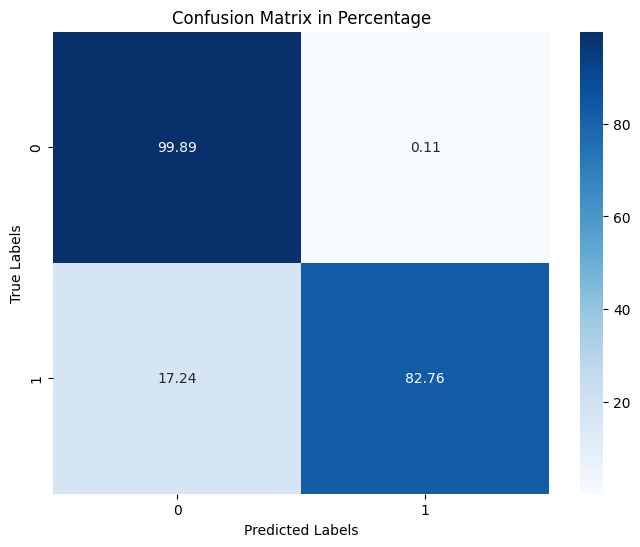

In [505]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming you already have y_test and y_test_pred from your model predictions
# y_test and y_test_pred should be the true and predicted labels respectively

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Normalize the confusion matrix to get percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Generate class labels automatically from y_test
class_labels = np.unique(y_test)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

# Add labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix in Percentage')

# Show the plot
plt.show()


The false negative percentage is less than false positive percentage because the dataset contains a majority from the "Ham" category in the target variable .

**Future work**

More hyperparameter tuning could be performed to optimise model performance 

deep learning architectures could be explored for potential improvements